In [39]:
import pandas as pd
import numpy as np
import json
import os
import pathlib
import warnings
from joblib import load

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression

from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [40]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir,"wyscout_data", "events_data")

df = pd.DataFrame()

# Get all JSON files in the directory
json_files = [f for f in os.listdir(events_path) if f.endswith('.json')]

# Load each file and concatenate to the dataframe
for file_name in json_files:
    path = os.path.join(events_path, file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

df = df.reset_index()
df.head()

,index,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type,...,team,opponentTeam,player,pass,shot,groundDuel,aerialDuel,infraction,carry,possession
0,0,2384313747,5588197,1H,0,2,00:00:02.559,3.559115,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 286831, 'name': 'D. Solanke', 'position...","{'accurate': True, 'angle': -159, 'height': No...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
1,1,2384313748,5588197,1H,0,4,00:00:04.324,5.324929,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 413582, 'name': 'Y. Bissouma', 'positio...","{'accurate': True, 'angle': 62, 'height': None...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
2,2,2384313771,5588197,1H,0,6,00:00:06.973,7.973209,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 551442, 'name': 'Pedro Porro', 'positio...","{'accurate': True, 'angle': -95, 'height': Non...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
3,3,2384313772,5588197,1H,0,8,00:00:08.768,9.768278,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 413582, 'name': 'Y. Bissouma', 'positio...","{'accurate': True, 'angle': -135, 'height': No...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."
4,4,2384313775,5588197,1H,0,10,00:00:10.769,11.769625,2.384314e+09,"{'primary': 'pass', 'secondary': ['forward_pas...",...,"{'id': 1624, 'name': 'Tottenham Hotspur'}","{'id': 1625, 'name': 'Manchester City'}","{'id': 136441, 'name': 'B. Davies', 'position'...","{'accurate': True, 'angle': 32, 'height': None...",None,None,None,None,None,"{'id': 2384313747, 'duration': '9.752984', 'ty..."


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480511 entries, 0 to 480510
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           480511 non-null  int64  
 1   id              480511 non-null  int64  
 2   matchId         480511 non-null  int64  
 3   matchPeriod     480511 non-null  object 
 4   minute          480511 non-null  int64  
 5   second          480511 non-null  int64  
 6   matchTimestamp  480511 non-null  object 
 7   videoTimestamp  480511 non-null  object 
 8   relatedEventId  452956 non-null  float64
 9   type            480511 non-null  object 
 10  location        480150 non-null  object 
 11  team            480511 non-null  object 
 12  opponentTeam    480511 non-null  object 
 13  player          480511 non-null  object 
 14  pass            274869 non-null  object 
 15  shot            6971 non-null    object 
 16  groundDuel      77664 non-null   object 
 17  aerialDuel

# Preparing the data for possession chains

We'll analyse passes that happened 15 seconds before a shot later but it doesn't make a lot of sense to assign xG and quickShot values to shots from previous possession chains.

For example: we have the ball and play some passes, we lose the ball, recover, make some other passes and finally shoot at goal. To me that process describes two different possession chains where only the second one really contributes to the shot/goal. But if those events happen close to each other, passes from the first chain would get xG and quickShot values. Which isn't correct in my opinion.


In [51]:
# Split the type column
df["primaryType"] = df["type"].apply(lambda x: x["primary"] if isinstance(x, dict) else None)
df["secondaryType"] = df["type"].apply(lambda x: x["secondary"] if isinstance(x, dict) else [])

# Look at next event
next_event = df.shift(-1, fill_value=0)
df["nextPrimaryType"] = next_event["primaryType"]
df["nextSecondaryType"] = next_event["secondaryType"]
df["kickedOut"] = df["nextSecondaryType"].apply(lambda x: 'ball_out' in x if isinstance(x, list) else False)
print(f"Init: {df.shape}")

# Drop game interruptions
df = df[~df["primaryType"].isin(["game_interruption"])]
print(f"Dropped game interruptions: {df.shape}")

# Drop lost duels
df = df[~((df["primaryType"] == "duel") & (df["secondaryType"].apply(lambda x: "loss" in x)))]
print(f"Dropped lost duels: {df.shape}")

# Drop save attempts
save_types = ["save", "save_with_reflex", "penalty_save"]
df = df[~df["secondaryType"].apply(lambda x: any(save_type in x for save_type in save_types) if isinstance(x, list) else False)]
print(f"Dropped save attempts: {df.shape}")

Init: (448240, 26)
Dropped game interruptions: (448240, 26)
Dropped lost duels: (448240, 26)
Dropped save attempts: (446433, 26)


Secondary types
- aerial_duel
- assist
- back_pass
- ball_out
- carry
- conceded_goal
- counterpressing_recovery
- cross
- cross_blocked
- deep_completed_cross
- deep_completion
- defensive_duel
- dribble
- dribbled_past_attempt
- forward_pass
- foul
- foul_suffered
- free_kick_cross
- free_kick_shot
- goal
- ground_duel
- hand_pass
- head_pass
- head_shot
- key_pass
- lateral_pass
- linkup_play
- long_pass
- loose_ball_duel
- loss
- offensive_duel
- opportunity
- pass_into_penalty_area
- pass_to_final_third
- penalty_conceded_goal
- penalty_foul
- penalty_goal
- penalty_save
- pressing_duel
- progressive_pass
- progressive_run
- recovery
- red_card
- save
- save_with_reflex
- second_assist
- short_or_medium_pass
- shot_after_corner
- shot_after_free_kick
- shot_after_throw_in
- shot_assist
- shot_block
- sliding_tackle
- smart_pass
- third_assist
- through_pass
- touch_in_box
- under_pressure
- whistle
- yellow_card

# Isolating possession chains

In [14]:
df.head()

,index,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type,...,carry,possession,primaryType,secondaryType,nextPrimaryType,nextSecondaryType,kickedOut,x0,y0,c0
0,0,2384313747,5588197,1H,0,2,00:00:02.559,3.559115,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,None,"{'id': 2384313747, 'duration': '9.752984', 'ty...",pass,"[back_pass, short_or_medium_pass]",pass,"[lateral_pass, short_or_medium_pass]",False,54.60,32.64,1.36
1,1,2384313748,5588197,1H,0,4,00:00:04.324,5.324929,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,None,"{'id': 2384313747, 'duration': '9.752984', 'ty...",pass,"[lateral_pass, short_or_medium_pass]",pass,"[lateral_pass, short_or_medium_pass]",False,38.85,39.44,5.44
2,2,2384313771,5588197,1H,0,6,00:00:06.973,7.973209,2.384314e+09,"{'primary': 'pass', 'secondary': ['lateral_pas...",...,None,"{'id': 2384313747, 'duration': '9.752984', 'ty...",pass,"[lateral_pass, short_or_medium_pass]",pass,"[back_pass, short_or_medium_pass]",False,47.25,23.80,10.20
3,3,2384313772,5588197,1H,0,8,00:00:08.768,9.768278,2.384314e+09,"{'primary': 'pass', 'secondary': ['back_pass',...",...,None,"{'id': 2384313747, 'duration': '9.752984', 'ty...",pass,"[back_pass, short_or_medium_pass]",pass,"[forward_pass, short_or_medium_pass]",False,46.20,36.04,2.04
4,4,2384313775,5588197,1H,0,10,00:00:10.769,11.769625,2.384314e+09,"{'primary': 'pass', 'secondary': ['forward_pas...",...,None,"{'id': 2384313747, 'duration': '9.752984', 'ty...",pass,"[forward_pass, short_or_medium_pass]",touch,[loss],False,35.70,46.24,12.24


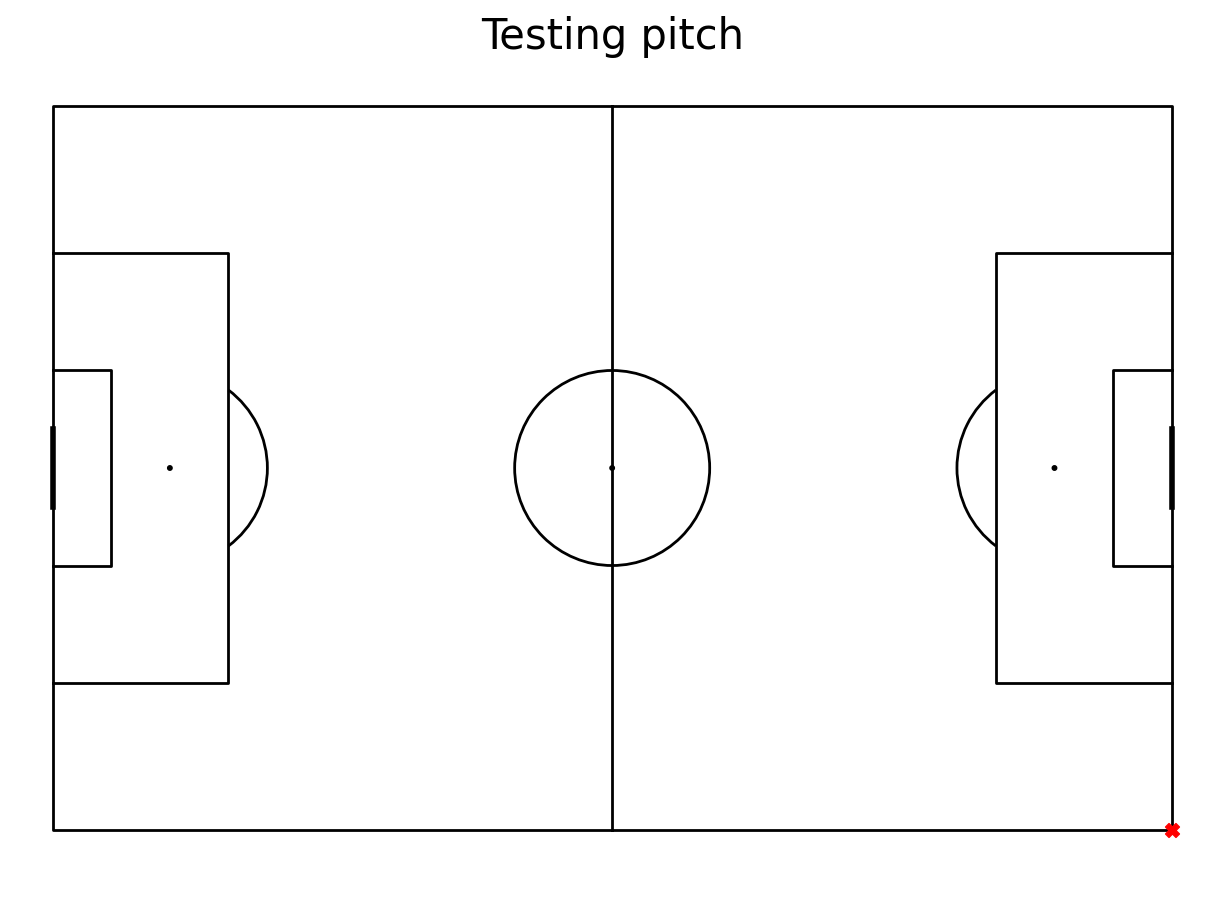

In [10]:
# Init pitch
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Scatter points as test
pitch.scatter(105, 0, color="red", marker="X", s=100, ax=ax["pitch"], zorder=4)

ax['title'].text(0.5, 0.5, 'Testing pitch', ha='center', va='center', fontsize=30)
plt.show()

In [ ]:
# Filter out actions that ended with the ball going out
df = df[~df["kickedOut"]]

# Only keep passes and shots (expand later)
df = df[df["primaryType"].isin(["pass", "shot"])]
#df = df[df["primaryType"].isin(["pass", "shot", "free_kick", "clearance", "corner", "goal_kick", "penalty"])]

# Create columns for starting coordinates of the ball
df["x0"] = df["location"].apply(lambda cell: (cell["x"]) * 105/100)
df["y0"] = df["location"].apply(lambda cell: abs(100 - cell["y"]) * 68/100)
df["c0"] = df["location"].apply(lambda cell: abs(50 - cell["y"]) * 68/100)

# Create columns for ending coordinates of the ball
# For passes
if df["primaryType"] == "pass":
#df["x1"] = df["location"].apply(lambda cell: (cell[1]["x"]) * 105/100)
#df["y1"] = df["location"].apply(lambda cell: abs(100 - cell[1]["y"]) * 68/100)
#df["c1"] = df["location"].apply(lambda cell: abs(50 - cell[1]["y"]) * 68/100)

df.info()